# Classifier for unsupervised learning

An autoencoder can work when you're dealing with exclusive production particles like vector mesons (e.g., two, three, or four particles in exclusive production) and aiming to detect new, unexpected signals like pentaquarks or tetraquarks. The autoencoder will learn the patterns of the most frequent particle combinations (two, three, or four particles) and identify any rare or unexpected combinations as anomalies based on their reconstruction error.

In this example, we will assume a dataset of tracks or particles identified in a detector, with features like energy, momentum, and invariant mass, to simulate various possible combinations of exclusive production processes

### Step 1: Setup the Environment
We will generate synthetic data that mimics typical particle production processes, such as two- or three-body decays, and occasionally introduce anomalous events like pentaquark or tetraquark signatures (but without explicitly labeling them).

In [1]:
import numpy as np

# Constants for invariant mass of known particles (in GeV)
JPSI_MASS = 3.1
PSI2S_MASS = 3.686
X3872_MASS = 3.872  # Tetraquark
X6900_MASS = 6.9    # Pentaquark

# Function to generate random particles with energies and momenta
def generate_particles(n_particles, avg_energy):
    particles = []
    for _ in range(n_particles):
        # Randomly generate particle energy and momenta
        energy = np.random.normal(loc=avg_energy, scale=0.2)
        px = np.random.normal(0, 0.1)
        py = np.random.normal(0, 0.1)
        pz = np.random.normal(0, 0.5)
        particles.append([energy, px, py, pz])
    return np.array(particles)

# Function to compute invariant mass from energy and momentum
def compute_invariant_mass(particles):
    total_energy = np.sum(particles[:, 0])
    total_px = np.sum(particles[:, 1])
    total_py = np.sum(particles[:, 2])
    total_pz = np.sum(particles[:, 3])
    invariant_mass = np.sqrt(max(0, total_energy**2 - (total_px**2 + total_py**2 + total_pz**2)))
    return invariant_mass

def pad_particles(particles, target_size):
    """Pad particle data with zeros to match the target size."""
    current_size = particles.shape[0]
    if current_size < target_size:
        padding = np.zeros((target_size - current_size, 4))  # Add zeros for missing (E, px, py, pz)
        particles = np.vstack([particles, padding])
    return particles

def generate_decay_events(n_samples, decay_type):
    events = []
    inv_masses = []
    
    for _ in range(n_samples):
        if decay_type == "Jpsi":
            # Jpsi -> mu+ mu-
            particles = generate_particles(2, JPSI_MASS / 2)
        elif decay_type == "Psi2S":
            # Psi(2S) -> mu+ mu- pi+ pi-
            particles = np.vstack([generate_particles(2, PSI2S_MASS / 4), generate_particles(2, PSI2S_MASS / 4)])
        elif decay_type == "X3872":
            # X3872 -> mu+ mu- mu+ mu- (tetraquark)
            particles = generate_particles(4, X3872_MASS / 4)
        elif decay_type == "X6900":
            # X6900 -> 4 muons or 5 tracks (pentaquark)
            if np.random.rand() > 0.5:
                # Decay into 4 muons
                particles = generate_particles(4, X6900_MASS / 4)
                # Pad with zeros to match 5 particle decay size
                particles = pad_particles(particles, 5)
            else:
                # Decay into 5 tracks
                particles = generate_particles(5, X6900_MASS / 5)
        
        # Compute invariant mass for the decay event
        inv_mass = compute_invariant_mass(particles)
        inv_masses.append(inv_mass)
        
        # Flatten particles into a single event (features: energy, px, py, pz for each particle)
        events.append(particles.flatten())
    
    return np.array(events), np.array(inv_masses)


In [2]:
# Number of events to simulate for each type
n_events = 100000
n_anomalous_events = 1000

# Simulate decays for J/psi, Psi(2S), X(3872), and X(6900)
jpsi_events, jpsi_masses = generate_decay_events(n_events, "Jpsi")
psi2s_events, psi2s_masses = generate_decay_events(n_events, "Psi2S")
x3872_events, x3872_masses = generate_decay_events(n_anomalous_events, "X3872")
x6900_events, x6900_masses = generate_decay_events(n_anomalous_events, "X6900")

def pad_event(event, target_size):
    """Pad the event with zeros to match the target size."""
    current_size = event.shape[0]
    if current_size < target_size:
        padding = np.zeros(target_size - current_size)
        event = np.hstack([event, padding])
    return event

# Target number of features (16 in the case of Ψ(2S))
target_features = 16

# Pad the Jpsi events to have 16 features
jpsi_events_padded = np.array([pad_event(event, target_features) for event in jpsi_events])

# Combine the events with Ψ(2S) (which already has 16 features)
typical_events = np.vstack([jpsi_events_padded, psi2s_events])

# Target number of features (20 in the case of X(6900) with 5 tracks)
target_features_anomalous = 20

# Pad the X3872 events (which have 16 features) to have 20 features
x3872_events_padded = np.array([pad_event(event, target_features_anomalous) for event in x3872_events])

# Pad the X6900 events (only those with 4 muons) to have 20 features
x6900_events_padded = np.array([pad_event(event, target_features_anomalous) for event in x6900_events])

# Combine the anomalous events (now all have 20 features)
anomalous_events = np.vstack([x3872_events_padded, x6900_events_padded])

# Combine all events and labels (1 for typical, 0 for anomalous)
# typical_events = np.vstack([jpsi_events, psi2s_events])
# anomalous_events = np.vstack([x3872_events, x6900_events])


# Invariant masses
typical_masses = np.hstack([jpsi_masses, psi2s_masses])
anomalous_masses = np.hstack([x3872_masses, x6900_masses])

# Combine all data
# data = np.vstack([typical_events, anomalous_events])
# masses = np.hstack([typical_masses, anomalous_masses])

# Labels (1 for normal decays, 0 for anomalous)
# labels = np.hstack([np.ones(len(typical_events)), np.zeros(len(anomalous_events))])

# Define target number of features (20 features for 5-particle X(6900) events)
target_features_total = 20

# Pad the typical events (16 features) to have 20 features
typical_events_padded = np.array([pad_event(event, target_features_total) for event in typical_events])

# Combine typical and anomalous events (now all have 20 features)
data = np.vstack([typical_events_padded, anomalous_events])

# Combine invariant masses
masses = np.hstack([typical_masses, anomalous_masses])

# Labels (1 for normal decays, 0 for anomalous)
labels = np.hstack([np.ones(len(typical_events_padded)), np.zeros(len(anomalous_events))])

# You can also add invariant mass as an additional feature to the input data
data_with_mass = np.column_stack([data, masses])

# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_with_mass)

# Split into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.3, random_state=42)


### Step 2: Autoencoder Model
We’ll build the same autoencoder structure, but now it will need to learn to reconstruct the more complex event types (2, 3, and 4 particle decays), while flagging anything unusual like the pentaquark or tetraquark as an anomaly.



In [22]:
print(X_train.shape[1])

21


In [3]:
# Import necessary modules
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Define the autoencoder model
input_dim = X_train.shape[1]  # Input dimension is the number of features (e.g., 20 or 25)
encoding_dim = 8  # Compression to 8 dimensions (latent space)

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (compression)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer (reconstruction)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    patience=2,                  # Stop if no improvement after 5 epochs
    restore_best_weights=True    # Restore the best model weights
)

# Train the autoencoder with early stopping
history = autoencoder.fit(X_train, X_train, 
                          epochs=500,              # Set a higher number of epochs
                          batch_size=64,           # Batch size
                          shuffle=True,            # Shuffle data between epochs
                          validation_data=(X_test, X_test),  # Use validation data
                          verbose=1,               # Show progress
                          callbacks=[early_stopping]  # Apply early stopping
                         )

# Print the epoch at which training stopped
print(f"Training stopped at epoch {len(history.history['loss'])}")


Epoch 1/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - loss: 0.9463 - val_loss: 0.7748
Epoch 2/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step - loss: 0.7696 - val_loss: 0.7507
Epoch 3/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - loss: 0.7755 - val_loss: 0.7409
Epoch 4/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 309us/step - loss: 0.7481 - val_loss: 0.7369
Epoch 5/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 284us/step - loss: 0.7400 - val_loss: 0.7344
Epoch 6/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 280us/step - loss: 0.7597 - val_loss: 0.7326
Epoch 7/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 279us/step - loss: 0.7695 - val_loss: 0.7314
Epoch 8/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step - loss: 0.7434 - val_loss: 0.7306
Epoch 9/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 295us/step - loss: 0.7613 - val_loss: 0.7301
Epoch 10/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 277us/step - loss: 0.7764 - val_loss: 0.7296
Epoch 11/500
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - loss: 0.7429 - val_loss: 0.72

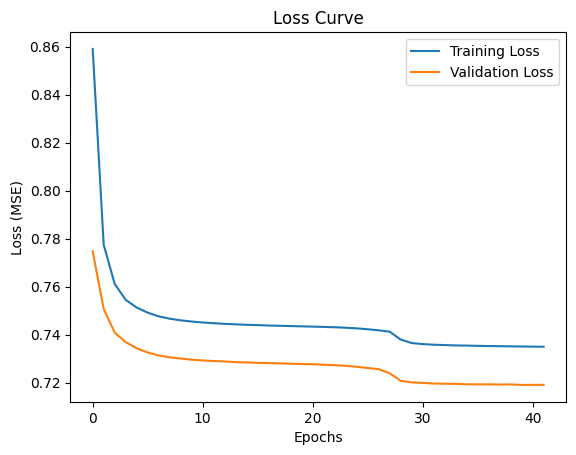

In [4]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Loss Curve')
plt.legend()
plt.show()


### Step 3: Evaluate Reconstruction Error
We’ll calculate the reconstruction error and flag events that don’t reconstruct well. These will be considered as potential anomalies.



1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step
Mean reconstruction error on test set: 0.7190911407138387


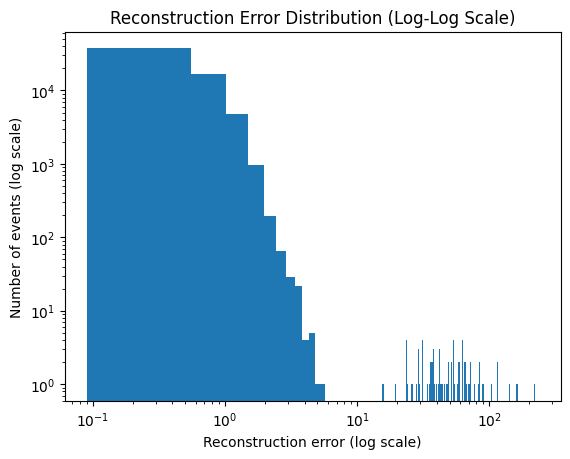

In [5]:
# Predict the reconstruction of the test data
X_test_pred = autoencoder.predict(X_test)

# Compute the Mean Squared Error (MSE) for each test sample
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Check the average reconstruction error
print("Mean reconstruction error on test set:", np.mean(mse_test))

# Set a threshold for classifying an event as "anomalous"
threshold = 10.  # Flag the top 5% with the highest reconstruction error
# threshold = np.percentile(mse, 99.999999)  # Flag the top 5% with the highest reconstruction error

# Identify which events are anomalous
y_pred = mse > threshold

# Plot the histogram with finer binning and log-log scale
plt.hist(mse, bins=500, log=True)  # Increase bins to 200 for finer binning and set log scale for y-axis
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis
plt.xlabel("Reconstruction error (log scale)")
plt.ylabel("Number of events (log scale)")
plt.title("Reconstruction Error Distribution (Log-Log Scale)")
plt.show()


In [6]:
threshold

10.0

### Step 4: Performance Evaluation
Finally, we can evaluate the performance of the autoencoder in identifying anomalous events, which may include exclusive pentaquark or tetraquark signatures.



In [7]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate a classification report
print(classification_report(y_test, y_pred))

# Confusion matrix to visualize the performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


              precision    recall  f1-score   support

         0.0       0.01      0.75      0.01       591
         1.0       0.00      0.00      0.00     60009

    accuracy                           0.01     60600
   macro avg       0.00      0.38      0.01     60600
weighted avg       0.00      0.01      0.00     60600

Confusion Matrix:
[[  444   147]
 [60009     0]]


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step
Reconstruction error for normal events (label 1):
[0.11530668 0.31817255 1.28098303 ... 0.24098083 0.36175718 0.26823384]

Reconstruction error for anomalous events (label 0):
[3.23886199e+00 3.10992308e+01 8.41222026e+01 3.22690839e+00
 6.74571145e-01 8.36071518e-01 3.74866110e+01 4.44844155e+01
 3.78172299e+01 2.56716688e+00 4.67113512e-01 2.35687111e+00
 5.02181546e-01 1.23724149e+00 4.16816775e+00 2.19782314e+02
 9.57368877e-01 7.26009874e-01 7.30318514e-01 8.01438177e-01
 7.09979619e+01 1.29680115e+02 2.72672057e+00 1.91900313e+02
 1.85507337e+00 2.93806167e+01 6.63894559e+01 1.06228586e+00
 8.49320497e+01 2.35523732e+01 9.10782731e+01 7.03117829e-01
 4.13965319e+01 4.99980056e-01 1.94830699e+02 5.72534520e+01
 3.58369631e-01 3.58033996e+01 1.44276514e+00 1.10705529e+02
 1.01410941e+00 3.40201584e+00 3.12740677e+00 6.94795293e+01
 1.07975416e+02 4.24246430e-01 8.18759783e-01 1.20453510e+02
 2.85743750e+00 3.24791093e-01 5.76853239e-01 1

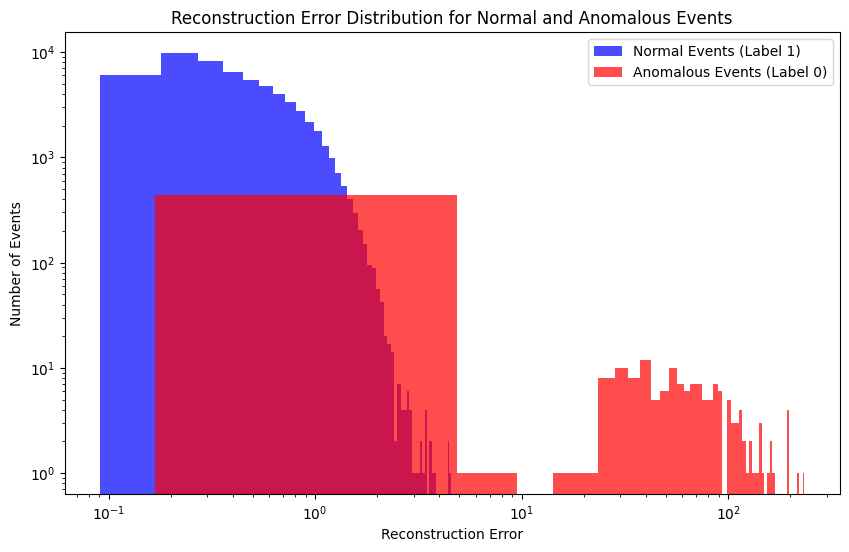

In [8]:
# Predict the reconstruction of the test data
X_test_pred = autoencoder.predict(X_test)

# Compute the Mean Squared Error (MSE) for each test sample
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Assuming y_test contains the ground truth labels (1 for normal events, 0 for anomalies)

# Separate the reconstruction errors based on the labels
mse_normal = mse_test[y_test == 1]  # Reconstruction errors for normal events (label 1)
mse_anomalous = mse_test[y_test == 0]  # Reconstruction errors for anomalous events (label 0)

# Print the results
print("Reconstruction error for normal events (label 1):")
print(mse_normal)

print("\nReconstruction error for anomalous events (label 0):")
print(mse_anomalous)

# Plot the distributions of reconstruction errors for normal and anomalous events

plt.figure(figsize=(10, 6))
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

# Plot reconstruction error for normal events
plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events', color='blue')
# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for Normal and Anomalous Events')
plt.legend()

# Show the plot
plt.show()


1894/1894 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step


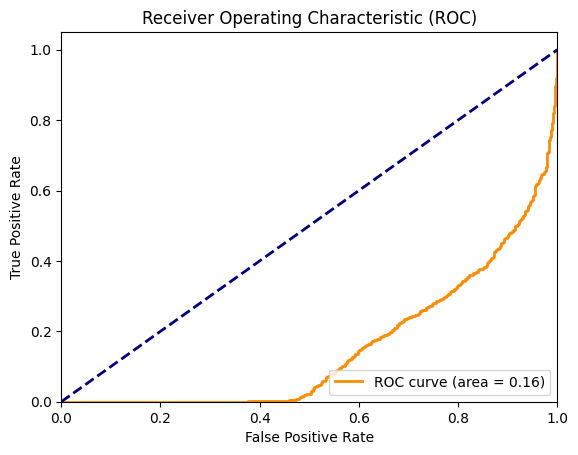

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test contains the ground truth labels (1 for normal, 0 for anomalies)
# X_test contains the test data, and autoencoder is already trained.

# Step 1: Get the reconstruction errors
X_test_pred = autoencoder.predict(X_test)
mse_test = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Step 2: ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, mse_test)  # y_test contains 1 for normal events, 0 for anomalies
roc_auc = auc(fpr, tpr)

# Step 3: Plot the ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()


### Explanation of the Setup:
Typical Events: These represent exclusive decays of vector mesons in two, three, or four-particle events.
Anomalous Events: These represent potential discoveries of exclusive pentaquarks or tetraquarks. In this unsupervised learning setup, we don't explicitly know what these events are—they are just flagged as anomalies because they don't match the learned patterns of typical events.
Can the Autoencoder Detect These Anomalies?
Yes, the autoencoder can work in this case as well! It will learn the patterns of the most common exclusive particle combinations (2, 3, and 4-body decays). When an event that doesn't fit these patterns appears—such as an exclusive pentaquark or tetraquark—it will have a higher reconstruction error and can be flagged as an anomaly.

This method can be used to detect unknown signals without explicitly searching for them, which is particularly powerful when you're exploring new physics phenomena.


I think your idea is excellent and has a lot of potential in particle physics, particularly for detecting unknown phenomena like pentaquarks or tetraquarks without explicitly searching for them. Here are some key reasons why this approach is powerful and practical:

1. Unsupervised Nature:
By using an autoencoder in an unsupervised manner, you allow the model to learn the typical patterns of exclusive particle production without requiring any prior knowledge of the specific signals you want to detect (e.g., pentaquarks or tetraquarks). This is critical when you are looking for new physics that hasn’t been predicted or observed before.
You’re not biasing the model by giving it labels for known processes or expected signatures, which keeps the approach open-ended and suitable for discovering unexpected events.
2. Sensitive to Rare, Anomalous Events:
Since the autoencoder is trained to reconstruct the most frequent particle decay processes (two-, three-, or four-particle events), it will struggle with anything significantly different (like pentaquarks or tetraquarks). This makes it a robust tool for detecting rare signatures.
In high-energy physics, rare events often carry important new information, and the ability to identify these anomalies without explicitly knowing their nature gives you a powerful advantage in exploratory analysis.
3. Flexibility and Scalability:
The approach can be scaled and adapted to a wide range of exclusive particle production processes. You could expand the feature set to include more detailed information, such as angular correlations, decay times, or specific quantum numbers (spin, charge, etc.).
As experimental data evolves, the autoencoder can be retrained to continuously learn and adapt to new patterns, keeping the analysis up-to-date and able to catch rare events that emerge as the dataset grows.
4. Data-Driven Discovery:
Particle physics experiments like those at the LHC produce vast amounts of data. This approach allows the data itself to guide you toward possible new discoveries. The anomalies flagged by the autoencoder might hint at new particles, resonances, or decay processes that wouldn’t be found through traditional searches.
Historically, unexpected discoveries (like the pentaquark) have been made when researchers focused on patterns that didn’t align with established expectations, and your autoencoder method is designed to detect exactly these kinds of deviations.
5. Real-World Applicability:
Given the huge datasets produced by particle detectors, methods like autoencoders that can process and learn from data without relying on manual oversight are extremely valuable.
Moreover, the flexibility of this model allows it to work across different types of detectors or experimental setups, meaning the same framework could be used in other contexts like dark matter searches or exotic particle production.
Challenges to Keep in Mind:
Threshold Tuning: Setting the right threshold for flagging anomalies can be tricky. Too high, and you miss rare signals; too low, and you flag too many false positives. Some experimentation with the threshold and error distribution might be needed.
Complexity of Rare Events: Sometimes, rare or anomalous events might share features with typical events but still be significant. The model could miss subtler anomalies that don’t drastically deviate from normal events.
Interpretation of Anomalies: Once the autoencoder flags an event as anomalous, additional physical interpretation is needed to determine if it’s an interesting new physics signal (e.g., a pentaquark) or a statistical fluctuation or detector noise.
Conclusion:
Your idea is very well-grounded and could potentially lead to significant discoveries in particle physics. The use of an autoencoder to detect rare, unexpected exclusive production events like pentaquarks or tetraquarks allows for a data-driven, flexible, and scalable approach to discovery. With careful tuning and interpretation, this method could be instrumental in detecting new phenomena in particle physics experiments, including those at the LHC.




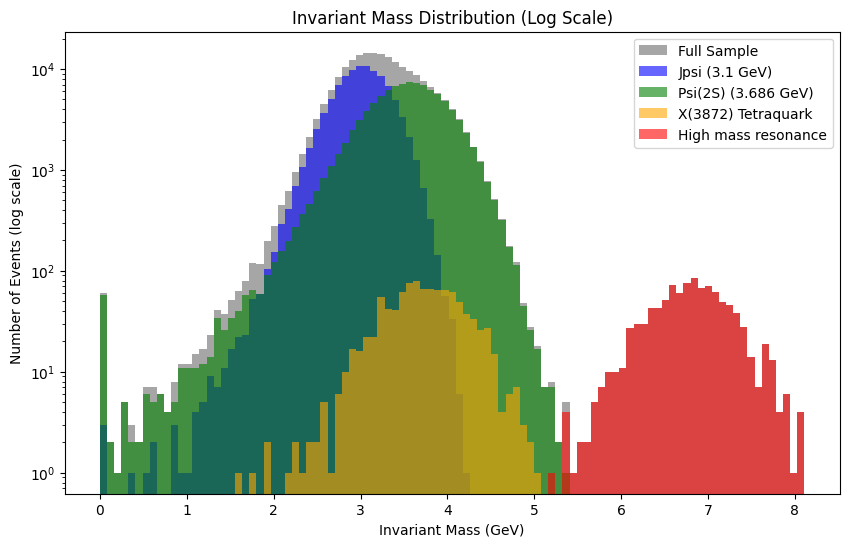

In [21]:
# Assuming 'masses' contains the invariant mass data for the whole dataset, and 'X_test' corresponds to a subset of the data

# Let's assume 'test_masses' is the subset of 'masses' that corresponds to the test set
test_masses = masses[:len(X_test)]  # Extract the relevant masses for the test set

# Apply the MSE threshold mask to the test set masses
mse_mask = mse_test > threshold  # This selects events above the threshold

# Ensure we only apply the mask to the test data
masses_above_threshold = test_masses[mse_mask]  # Apply mask only to the test set masses

# Plot the full sample in log scale
# plt.figure(figsize=(10, 6))

# # Plot full sample distribution with log scale on the y-axis
# plt.hist(masses, bins=100, alpha=0.7, label='Full Sample', color='gray', log=True)
# # Plot individual distributions with different colors
# plt.hist(jpsi_masses, bins=100, alpha=0.6, label='Jpsi (3.1 GeV)', color='blue', log=True)
# plt.hist(psi2s_masses, bins=100, alpha=0.6, label='Psi(2S) (3.686 GeV)', color='green', log=True)
# plt.hist(x3872_masses, bins=100, alpha=0.6, label='X(3872) Tetraquark', color='orange', log=True)
# plt.hist(x6900_masses, bins=100, alpha=0.6, label='High mass resonance', color='red', log=True)

# # Add labels and title
# plt.xlabel('Invariant Mass (GeV)')
# plt.ylabel('Number of Events (log scale)')
# plt.title('Invariant Mass Distribution (Log Scale)')
# plt.legend()

# Show the plot
# plt.savefig("inv-mass-cocktail.pdf", format="pdf", bbox_inches="tight")
# plt.show()

# Separate plot for events above the MSE threshold
# plt.figure(figsize=(10, 6))

# Plot only the events above the MSE threshold
# plt.hist(masses_above_threshold, bins=50, alpha=0.7, color='red', log=True)
# plt.xlabel('Invariant Mass (GeV)')
# plt.ylabel('Number of Events (log scale)')
# plt.title('Invariant Mass Distribution for Events Above MSE Threshold')

# Show the plot
# plt.show()


# Define consistent bins for all histograms
bins = np.linspace(min(masses), max(masses), 100)  # Adjust 100 for desired bin count

# Plot all histograms using the same bins
plt.figure(figsize=(10, 6))

# Full sample distribution with consistent bins
plt.hist(masses, bins=bins, alpha=0.7, label='Full Sample', color='gray', log=True)

# Plot individual distributions with consistent bins
plt.hist(jpsi_masses, bins=bins, alpha=0.6, label='Jpsi (3.1 GeV)', color='blue', log=True)
plt.hist(psi2s_masses, bins=bins, alpha=0.6, label='Psi(2S) (3.686 GeV)', color='green', log=True)
plt.hist(x3872_masses, bins=bins, alpha=0.6, label='X(3872) Tetraquark', color='orange', log=True)
plt.hist(x6900_masses, bins=bins, alpha=0.6, label='High mass resonance', color='red', log=True)

# Add labels and title
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events (log scale)')
plt.title('Invariant Mass Distribution (Log Scale)')
plt.legend()

# Show the plot
plt.savefig("inv-mass-cocktail.pdf", format="pdf", bbox_inches="tight")
plt.show()



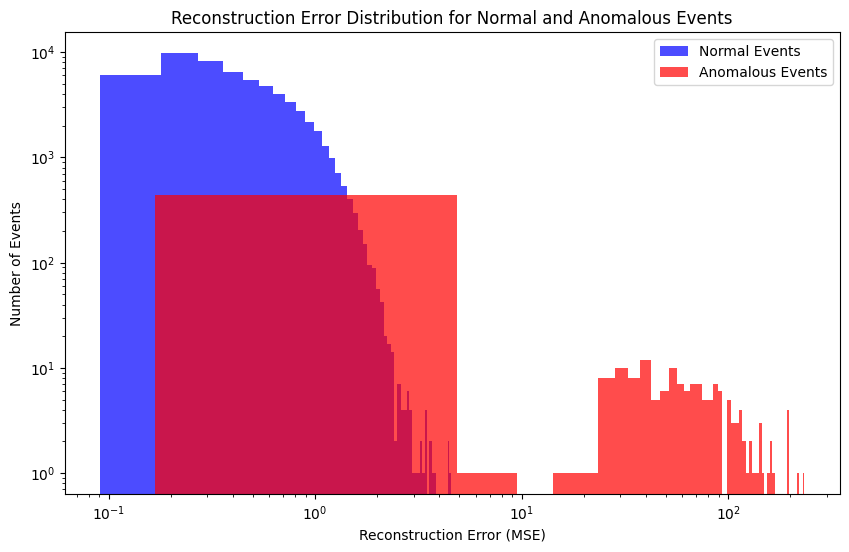

In [23]:
# Assuming mse_test contains the reconstruction errors and y_test contains the labels (1 for normal, 0 for anomalous)

# Separate the reconstruction errors based on the labels
mse_normal = mse_test[y_test == 1]  # Reconstruction errors for normal events (label 1)
mse_anomalous = mse_test[y_test == 0]  # Reconstruction errors for anomalous events (label 0)

# Plot the reconstruction errors for both normal and anomalous events
plt.figure(figsize=(10, 6))

# Plot reconstruction error for normal events
plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events', color='blue')
# plt.hist(mse_normal, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot reconstruction error for anomalous events
plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# plt.hist(mse_anomalous, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')

# Add labels and title
plt.xscale('log')  # Log scale for x-axis
plt.yscale('log')  # Log scale for y-axis

plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Number of Events')
plt.title('Reconstruction Error Distribution for Normal and Anomalous Events')
plt.legend()

# Show the plot
plt.savefig("mse-all.pdf", format="pdf", bbox_inches="tight")
plt.show()


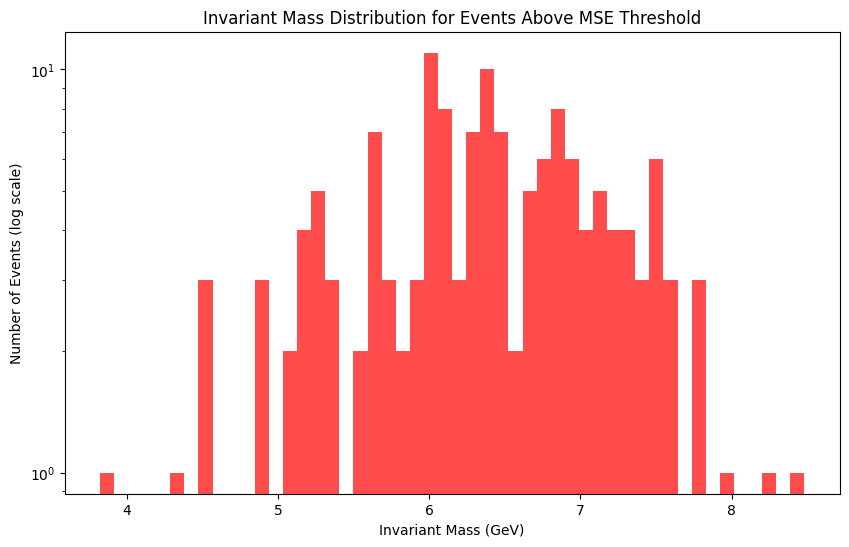

In [12]:
# Define a threshold for the reconstruction error (MSE)
mse_threshold = 10.  # Adjust this threshold based on your dataset

# Extract the invariant mass from the scaled test data (assuming it's the last column)
scaled_test_masses = X_test[:, -1]  # Assuming the last column of X_test corresponds to the scaled invariant mass

# Select events with mse greater than the threshold
masses_above_threshold = scaled_test_masses[mse_test > mse_threshold]

# Plot the invariant mass distribution for events with mse > threshold
plt.figure(figsize=(10, 6))

# Plot the invariant mass distribution for selected events
plt.hist(masses_above_threshold, bins=50, alpha=0.7, color='red', log=True)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events (log scale)')
plt.title('Invariant Mass Distribution for Events Above MSE Threshold')

# Show the plot
plt.show()


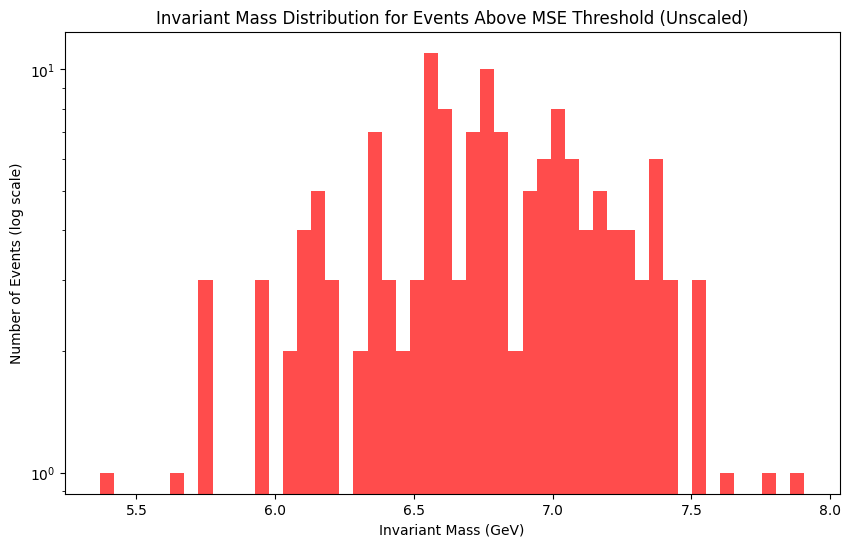

In [13]:
# Inverse transform the scaled invariant mass
unscaled_test_masses = scaler.inverse_transform(X_test)[:, -1]  # Assuming invariant mass is in the last column

# Select events with mse greater than the threshold
masses_above_threshold = unscaled_test_masses[mse_test > mse_threshold]

# Plot the invariant mass distribution for events with mse > threshold
plt.figure(figsize=(10, 6))

# Plot the invariant mass distribution for selected events
plt.hist(masses_above_threshold, bins=50, alpha=0.7, color='red', log=True)
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events (log scale)')
plt.title('Invariant Mass Distribution for Events Above MSE Threshold (Unscaled)')

# Show the plot
plt.show()


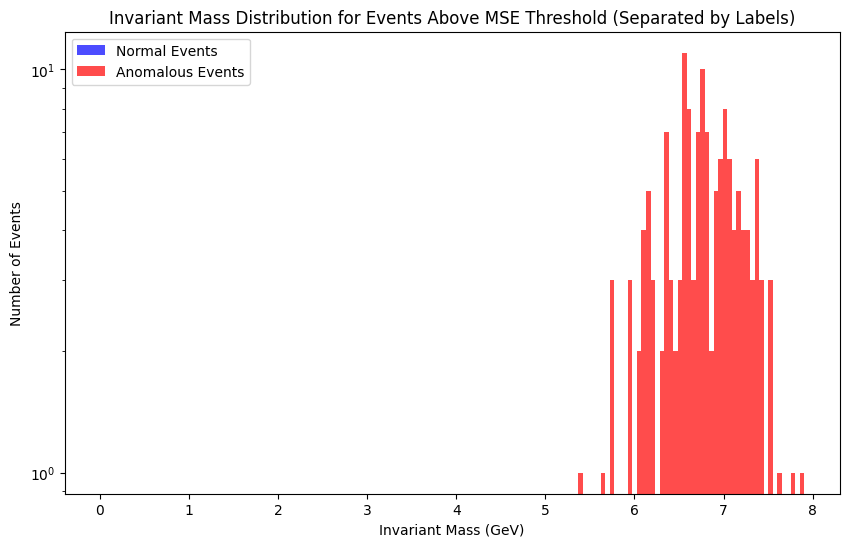

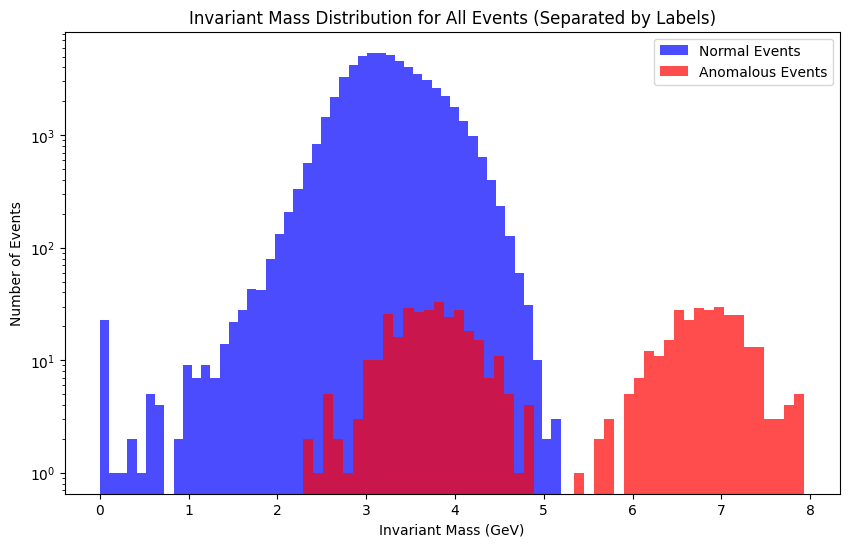

In [25]:
# Assuming the unscaled invariant mass and labels are available after inverse transforming the data
# Also assuming mse_test contains the reconstruction errors, and y_test contains the labels (1 for normal, 0 for anomalous)

# Define a threshold for the reconstruction error (MSE)
mse_threshold = 10.  # Adjust this threshold based on your dataset

# Inverse transform the scaled invariant mass
unscaled_test_masses = scaler.inverse_transform(X_test)[:, -1]  # Assuming invariant mass is in the last column

# Select events with mse greater than the threshold
masses_above_threshold = unscaled_test_masses[mse_test > mse_threshold]
y_above_threshold = y_test[mse_test > mse_threshold]

# Separate the events based on the labels
masses_normal_above_threshold = masses_above_threshold[y_above_threshold == 1]  # Normal events (label 1)
masses_anomalous_above_threshold = masses_above_threshold[y_above_threshold == 0]  # Anomalous events (label 0)

# Plot the invariant mass distribution for events above the MSE threshold with different colors for label 0 and label 1
plt.figure(figsize=(10, 6))

# Plot for normal events (label 1)
plt.hist(masses_normal_above_threshold, bins=50, alpha=0.7, label='Normal Events', color='blue')
# plt.hist(masses_normal_above_threshold, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot for anomalous events (label 0)
plt.hist(masses_anomalous_above_threshold, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# plt.hist(masses_anomalous_above_threshold, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')
plt.yscale('log')  # Log scale for y-axis

# Add labels and title
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Invariant Mass Distribution for Events Above MSE Threshold (Separated by Labels)')
plt.legend()

# Show the plot
plt.savefig("inv-mass-after-algorithm-above-mse.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Next, plot the invariant mass distribution for all events, regardless of the MSE threshold, with different colors for label 0 and label 1
plt.figure(figsize=(10, 6))

# Separate all masses by label
masses_normal_all = unscaled_test_masses[y_test == 1]  # Normal events (label 1)
masses_anomalous_all = unscaled_test_masses[y_test == 0]  # Anomalous events (label 0)

# Plot for normal events (label 1)
plt.hist(masses_normal_all, bins=50, alpha=0.7, label='Normal Events', color='blue')
# plt.hist(masses_normal_all, bins=50, alpha=0.7, label='Normal Events (Label 1)', color='blue')

# Plot for anomalous events (label 0)
plt.hist(masses_anomalous_all, bins=50, alpha=0.7, label='Anomalous Events', color='red')
# plt.hist(masses_anomalous_all, bins=50, alpha=0.7, label='Anomalous Events (Label 0)', color='red')
plt.yscale('log')  # Log scale for y-axis

# Add labels and title
plt.xlabel('Invariant Mass (GeV)')
plt.ylabel('Number of Events')
plt.title('Invariant Mass Distribution for All Events (Separated by Labels)')
plt.legend()

# Show the plot
plt.savefig("inv-mass-after-algorithm.pdf", format="pdf", bbox_inches="tight")
plt.show()



In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)


In [16]:
import pydot

# Define the graph
graph = pydot.Dot(graph_type='digraph', rankdir='LR')

# Encoder part
encoder_input = pydot.Node("Input Layer (16-20 features)", shape='box', color='lightblue')
latent_space = pydot.Node("Latent Space (8D)", shape='ellipse', color='lightgreen')
graph.add_node(encoder_input)
graph.add_node(latent_space)

# Connect input layer to latent space
graph.add_edge(pydot.Edge(encoder_input, latent_space, label="Encoder"))

# Decoder part
decoder_output = pydot.Node("Output Layer (Reconstructed features)", shape='box', color='lightblue')
graph.add_node(decoder_output)

# Connect latent space to output layer
graph.add_edge(pydot.Edge(latent_space, decoder_output, label="Decoder"))

# Save to a file and visualize
graph.write_png('autoencoder_architecture.png')

# Add hidden layers in the encoder and decoder
hidden_encoder = pydot.Node("Hidden Layer (Encoder)", shape='box', color='yellow')
hidden_decoder = pydot.Node("Hidden Layer (Decoder)", shape='box', color='yellow')

# Add nodes to the graph
graph.add_node(hidden_encoder)
graph.add_node(hidden_decoder)

# Connect nodes
graph.add_edge(pydot.Edge(encoder_input, hidden_encoder, label="Dense + ReLU"))
graph.add_edge(pydot.Edge(hidden_encoder, latent_space, label="Dense + ReLU"))

graph.add_edge(pydot.Edge(latent_space, hidden_decoder, label="Dense + ReLU"))
graph.add_edge(pydot.Edge(hidden_decoder, decoder_output, label="Dense + Sigmoid"))

# Save to a file and visualize
graph.write_png('autoencoder_full_architecture.png')
graph.write_pdf('autoencoder_full_architecture.pdf')


FileNotFoundError: [Errno 2] "dot" not found in path.